# Heuristics - CVRP

In [1]:
from itertools import cycle

import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib as mpl
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## Instantiate data

In [2]:
# Import dataset
dataset = pd.read_csv("./data/tai150d.csv", index_col=0)
coordinates = dataset.loc[:, ["x", "y"]]
demands = dataset.d.values

In [3]:
# Determine addional parameters
capacity = 1874
n_vehicles = 14
N = coordinates.shape[0]

In [4]:
# Distance matrix from coordinates
distances = squareform(pdist(coordinates, metric="euclidean"))
distances = np.round(distances * 1e4, decimals=0).astype(int)

## Model

In [5]:
# Create the routing index manager: number of nodes, number of vehicles, depot node
manager = pywrapcp.RoutingIndexManager(
    N, n_vehicles, 0
)

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

### Parameters

In [6]:
# Same valid for any callback related to arcs/edges
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(distances[from_node, to_node] * 1e6)


transit_callback_index = routing.RegisterTransitCallback(distance_callback)

In [7]:
# Same valid for any callback related to nodes
def demand_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return int(demands[from_node])


demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

### Constraints

In [8]:
# Any constraint associated with vehicles can take same arguments
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    [capacity,] * n_vehicles,  # vehicle maximum capacities (list for each vehicle)
    True,  # start cumul to zero
    'Capacity'
)

True

### Objective

In [9]:
# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Solution

In [10]:
# Setting heuristic strategies
search_parameters = pywrapcp.DefaultRoutingSearchParameters()

# Constructive
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.CHRISTOFIDES
)

# Local search
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)

# Time-limit
search_parameters.time_limit.FromSeconds(300)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

In [11]:
print(f"{solution.ObjectiveValue() * 1e-6 :.2f}")

27364024.00


In [12]:
tours = []
for vehicle_id in range(n_vehicles):
    index = routing.Start(vehicle_id)
    tours.append([])
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        tours[-1].append(node_index)
    else:
        node_index = manager.IndexToNode(index)
        tours[-1].append(node_index)

print(tours)

[[0, 41, 85, 131, 122, 38, 45, 47, 57, 7, 0], [0, 59, 140, 144, 141, 149, 0], [0, 79, 135, 134, 137, 136, 66, 67, 71, 69, 68, 0], [0, 13, 115, 114, 116, 23, 14, 10, 0], [0, 6, 8, 9, 18, 20, 12, 28, 17, 25, 21, 19, 111, 24, 0], [0, 146, 148, 143, 72, 81, 0], [0, 94, 95, 48, 50, 0], [0, 78, 76, 73, 74, 77, 80, 145, 138, 139, 150, 0], [0, 1, 54, 53, 64, 58, 61, 65, 4, 51, 5, 11, 0], [0, 60, 56, 63, 36, 44, 39, 40, 33, 37, 42, 43, 35, 34, 46, 49, 129, 127, 132, 133, 124, 123, 125, 86, 82, 52, 62, 3, 55, 2, 0], [0, 98, 104, 108, 106, 105, 100, 101, 103, 102, 107, 75, 0], [0, 126, 130, 128, 84, 83, 0], [0, 22, 27, 16, 15, 118, 26, 113, 121, 110, 109, 117, 119, 112, 120, 93, 89, 87, 90, 92, 88, 91, 70, 0], [0, 147, 97, 99, 29, 30, 32, 31, 96, 142, 0]]


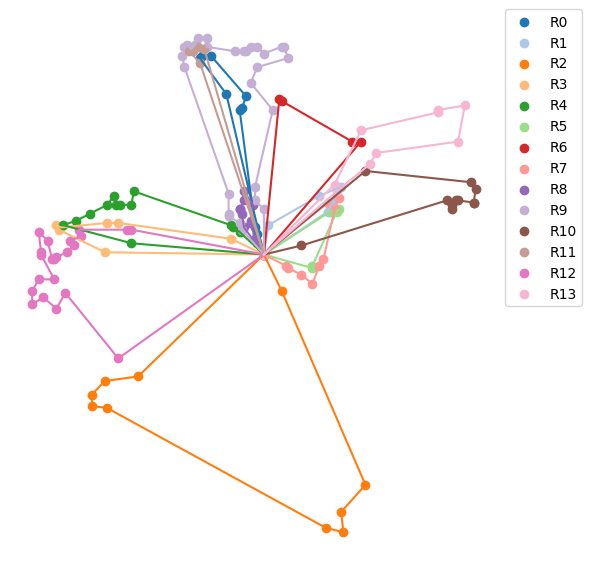

In [13]:
# Choosing colors
cmap = mpl.colormaps["tab20"]
colors = cycle(cmap.colors)

# Now the figure
fig, ax = plt.subplots(figsize=[6.5, 6], dpi=100)
for r, tour in enumerate(tours):
    c = next(colors)
    t = np.array(tour)
    x = coordinates.values[t, 0]
    y = coordinates.values[t, 1]
    ax.scatter(x, y, color=c, label=f"R{r}")
    ax.plot(x, y, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1.02))
fig.tight_layout()
plt.axis('off')
plt.savefig("vrp_sol_heur.png", transparent=True)
plt.show()